In this file I attempt to find respecting record in ACMS (input) dataset for each report in output dataset

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
acms = pd.read_csv('./a320_a321_neo_full_acms_parameters_202311140748.csv', parse_dates=['reportts']) \
    .drop(columns=[
        'processedts', 
        # 'file_path'
    ])

acnum = 'VQ-BGU'
# takeoff_reportname = 'A320 ENGINE TAKE OFF REPORT'
takeoff_reportname = 'A321 ENGINE TAKE OFF REPORT'
pos = 1

acms = acms[(acms['acnum'] == acnum) & (acms['reportname'] == takeoff_reportname)] \
    .drop(columns=['reportname']) \
    .set_index('reportts') \
    .sort_index()

acms

/home/b.korzh@group.s7/miniconda3/envs/recsys/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3269: DtypeWarning: Columns (139,151,170,174) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,acnum,pos,fltdes,dep,arr,ivs12,ibe,iaie,iai,zwbp,...,votm,vsva,w14,pf,wai,nai,prv,hpv,xf,reason
reportts,,,,,,,,,,,,,,,,,,,,,
2018-12-24 10:53:21,VQ-BGU,1,8990.0,EDHI,UUDD,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,1160.0,0.53,0.0,0.0,1.0,0.0,0.0,NaN
2018-12-24 10:53:21,VQ-BGU,2,8990.0,EDHI,UUDD,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,1160.0,0.53,0.0,0.0,1.0,0.0,0.0,NaN
2018-12-25 11:55:06,VQ-BGU,2,1023.0,UUDD,URSS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.51,0.0,1.0,1.0,0.0,0.0,NaN
2018-12-25 11:55:06,VQ-BGU,1,1023.0,UUDD,URSS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.51,0.0,1.0,1.0,0.0,0.0,NaN
2018-12-25 15:23:18,VQ-BGU,1,1024.0,URSS,UUDD,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,1179.0,0.53,0.0,0.0,1.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-23 10:24:44,VQ-BGU,1,5004.0,ULLI,UNNT,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,1241.0,0.53,0.0,0.0,1.0,0.0,0.0,NaN
2022-04-23 16:02:53,VQ-BGU,1,5237.0,UNNT,UHHH,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.51,0.0,0.0,1.0,0.0,0.0,NaN
2022-04-23 16:02:53,VQ-BGU,2,5237.0,UNNT,UHHH,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.51,0.0,0.0,1.0,0.0,0.0,NaN


In [22]:
egtm_raw = pd.read_csv('./EGTM_true.csv', parse_dates=['RECORDED_DT']) \
    .drop(columns=['ESN']) \
    .rename(columns={
        'AIRCRAFT': 'acnum',
        'POSITION': 'pos',
        'RECORDED_DT': 'recorded_dt',
        'RWCTOMAR': 'egtm'
    }) \
    .loc[:, :'egtm']

egtm_raw['recorded_dt'] = pd.to_datetime(egtm_raw['recorded_dt'], format='%m/%d/%Y %I:%M:%S', errors='raise')

egtm = egtm_raw[(egtm_raw['acnum'] == acnum)] \
    .set_index('recorded_dt') \
    .sort_index()

egtm

,acnum,pos,egtm
recorded_dt,,,
2018-12-24 10:53:22,VQ-BGU,1,44.437
2018-12-24 10:53:22,VQ-BGU,2,45.869
2018-12-25 15:23:23,VQ-BGU,1,44.379
2018-12-25 15:23:23,VQ-BGU,2,44.904
2018-12-25 20:49:27,VQ-BGU,1,43.742
...,...,...,...
2020-02-10 02:04:56,VQ-BGU,1,17.424
2020-02-10 17:24:01,VQ-BGU,2,16.755
2020-02-10 17:24:01,VQ-BGU,1,17.013


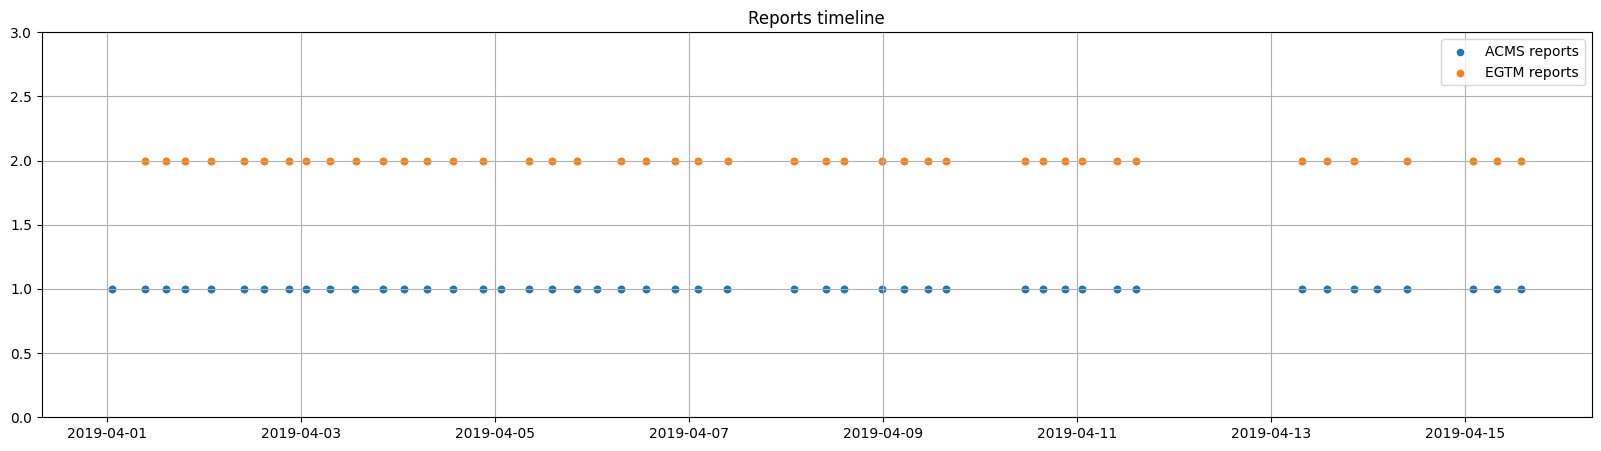

In [33]:
acms_filtered = acms[
    (pd.to_datetime(acms.index).year == 2019) &
    (pd.to_datetime(acms.index).month == 4) &
    (pd.to_datetime(acms.index).day <= 15)  
    # (pd.to_datetime(acms.index).day <= 21)
]

acms_line = acms_filtered.index

egtm_filtered = egtm[
    (pd.to_datetime(egtm.index).year == 2019) &
    (pd.to_datetime(egtm.index).month == 4) & 
    (pd.to_datetime(egtm.index).day <= 15) 
    # (pd.to_datetime(egtm.index).day <= 21) 
]

egtm_line = egtm_filtered.index

fig, ax = plt.subplots(figsize=(20, 5))

ax.scatter(acms_line, y=acms_line.map(lambda _ : 1), s=20)
ax.scatter(egtm_line, y=egtm_line.map(lambda _: 2), s=20)
ax.legend(["ACMS reports", "EGTM reports"])
ax.set_ylim([0, 3])
ax.set_title("Reports timeline")
ax.grid(which='minor', alpha=1)
ax.grid(which='major', alpha=1)
plt.show()

In [24]:
pd.concat([
    pd.Series(acms_line),
    pd.Series(acms_filtered['naiup'].to_numpy(), name='naiup'),
    pd.Series(acms_filtered['pos'].to_numpy()),
    pd.Series(egtm_line),
    pd.Series(egtm_filtered['egtm'].to_numpy(), name='egtm'),
], axis=1)

,reportts,naiup,0,recorded_dt,egtm
0,2019-03-01 08:01:16,127.6,2,2019-03-01 08:01:17,34.165
1,2019-03-01 08:01:16,128.5,1,2019-03-01 08:01:17,34.078
2,2019-03-01 12:03:15,126.8,2,2019-03-01 17:00:07,33.855
3,2019-03-01 12:03:15,129.1,1,2019-03-01 17:00:07,33.933
4,2019-03-01 17:00:06,128.4,2,2019-03-01 23:02:39,33.839
...,...,...,...,...,...
57,2019-03-10 11:59:51,128.2,2,NaT,NaN
58,2019-03-10 16:41:01,130.3,1,NaT,NaN
59,2019-03-10 16:41:01,130.1,2,NaT,NaN
60,2019-03-10 22:21:05,128.3,1,NaT,NaN


Гипотеза: output параметры вычислялись вскоре после записи input параметров 

In [25]:
def merge_by_date(left: pd.DataFrame, right: pd.DataFrame):
  left.sort_values('reportts', inplace=True)
  right.sort_values('reportts', inplace=True)
  right['reportts_'] = right['reportts'] 

  left = left.drop_duplicates('reportts').set_index('reportts')
  right = right.drop_duplicates('reportts').set_index('reportts')

  right_indexed = \
      right.reindex(left.index, method='ffill').reset_index()
  return pd.merge(left, right_indexed, on=['reportts', 'acnum', 'pos'], suffixes=(None, '_'))

def merge_both_engines(left: pd.DataFrame, right: pd.DataFrame, positions = [1, 2]):
  result = []
  
  for pos in positions:
    left_ = left[(left['pos'] == pos)].copy()
    right_ = right[(right['pos'] == pos)].copy()
    merged = merge_by_date(left_, right_)
    result.append(merged)

  return pd.concat(result, ignore_index=True)


merged = merge_both_engines( 
  egtm.reset_index().rename(columns={'recorded_dt': 'reportts'}),
  acms.reset_index()
)

diff = (merged['reportts'] - merged['reportts_']) \
        .astype('timedelta64[s]').astype('int')

merged_sample = merged[diff < 30]


In [26]:
merged_sample

,reportts,acnum,pos,egtm,fltdes,dep,arr,ivs12,ibe,iaie,...,vsva,w14,pf,wai,nai,prv,hpv,xf,reason,reportts_
0,2018-12-24 10:53:22,VQ-BGU,1,44.437,8990.0,EDHI,UUDD,NaN,NaN,NaN,...,0.0,1160.0,0.53,0.0,0.0,1.0,0.0,0.0,NaN,2018-12-24 10:53:21
1,2018-12-25 15:23:23,VQ-BGU,1,44.379,1024.0,URSS,UUDD,NaN,NaN,NaN,...,0.0,1179.0,0.53,0.0,0.0,1.0,0.0,0.0,NaN,2018-12-25 15:23:18
2,2018-12-25 20:49:27,VQ-BGU,1,43.742,217.0,UUDD,UNBB,NaN,NaN,NaN,...,0.0,1302.0,0.51,0.0,0.0,1.0,0.0,0.0,NaN,2018-12-25 20:49:26
3,2018-12-26 11:42:26,VQ-BGU,1,46.443,1045.0,UUDD,URSS,NaN,NaN,NaN,...,0.0,1252.0,0.01,0.0,1.0,0.0,0.0,0.0,NaN,2018-12-26 11:42:25
4,2018-12-26 15:19:13,VQ-BGU,1,47.660,1046.0,URSS,UUDD,NaN,NaN,NaN,...,0.0,1148.0,0.01,0.0,0.0,0.0,0.0,0.0,NaN,2018-12-26 15:19:12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1770,2020-02-05 05:07:31,VQ-BGU,2,17.670,2508.0,UNNT,UUDD,NaN,NaN,NaN,...,0.0,1177.0,0.03,0.0,0.0,0.0,0.0,0.0,NaN,2020-02-05 05:07:30
1772,2020-02-09 02:18:44,VQ-BGU,2,17.467,3062.0,UHBB,UUDD,NaN,NaN,NaN,...,0.0,1387.0,0.03,0.0,1.0,0.0,0.0,0.0,NaN,2020-02-09 02:18:34
1773,2020-02-10 02:04:56,VQ-BGU,2,17.079,3062.0,UHBB,UUDD,NaN,NaN,NaN,...,0.0,1325.0,0.03,0.0,0.0,0.0,0.0,0.0,NaN,2020-02-10 02:04:55
1774,2020-02-10 17:24:01,VQ-BGU,2,16.755,3061.0,UUDD,UHBB,NaN,NaN,NaN,...,0.0,1305.0,0.51,0.0,0.0,1.0,0.0,0.0,NaN,2020-02-10 17:23:51


Гипотеза верна, и для 1672 записей разница во времени *delta_t = output_t - input_t* составляет не более +30 секунд. Эти записи являются наиболее чистыми данными, которые в дальнейшем я буду использовать для построения baseline-моделей. Есть также небольшая часть данных, для которых delta_t отрицательна. На данный момент эти записи я не включаю в датасет, так как нет уверенности в их корректности. 

Датасет `takeoff-merged-VQ-BGU-30s.csv` будет основным для борта VQ-BGU.

**TODO**: добавить в датасет N1, N2, ETT (?)

**TODO**: аналогичным образом собрать датасет для VQ-BDQ

In [29]:
merged_sample.drop(columns=['reportts_']) \
             .to_csv('./takeoff-merged-VQ-BGU-30s.csv', index=False)

In [28]:
m = merged_sample
m[(m['reportts'] > '2019-12-19') & (m['reportts'] < '2019-12-20')][
    ['pos', 'reportts_', 'naiup', 'reportts', 'egtm']
]

,pos,reportts_,naiup,reportts,egtm
